In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, PowerTransformer, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
df = pd.read_csv('../data/insurance.csv')

X = df.drop('charges', axis=1)
y = df['charges']


In [3]:
num_features = ['age','bmi','children']
cat_features = ['sex','region','smoker']


In [9]:
def remove_outliers(df_in):
    df = df_in.copy()
    Q1 = df['charges'].quantile(0.25)
    Q3 = df['charges'].quantile(0.75)
    IQR = Q3 - Q1
    return df[(df['charges'] >= Q1 - 1.5*IQR) & (df['charges'] <= Q3 + 1.5*IQR)]

# FunctionTransformer for pipeline
outlier_transformer = FunctionTransformer(remove_outliers, validate=False)


In [4]:
# Pipeline for numerical features
num_pipeline = Pipeline([
    ('power', PowerTransformer(method='yeo-johnson')),  # correct skew
    ('scaler', StandardScaler())
])

# Pipeline for categorical features
cat_pipeline = Pipeline([
    ('ohe', OneHotEncoder(drop='first', sparse_output=False))
])

# Column transformer
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, cat_features)
])


In [10]:
def add_interactions(X_in):
    X = X_in.copy()
    # smoker: encode 0/1
    X['smoker_encoded'] = X['smoker'].map({'yes':1,'no':0})
    X['smoker_bmi'] = X['smoker_encoded'] * X['bmi']
    X['smoker_age'] = X['smoker_encoded'] * X['age']
    return X.drop('smoker_encoded', axis=1)

interaction_transformer = FunctionTransformer(add_interactions, validate=False)


In [ ]:
results = {}

for name, model in models.items():
    pipeline = Pipeline([
        ('interactions', interaction_transformer), 
        ('preprocessor', preprocessor),            
        ('regressor', model)                        
    ])
    
    cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring='r2')
    results[name] = cv_scores.mean()
    print(f"{name} CV R²: {cv_scores.mean():.4f}")


Linear Regression CV R²: 0.7452
Ridge Regression CV R²: 0.7452
Random Forest CV R²: 0.8363


### Model Comparison
- Random Forest achieved the highest CV R².
- Reasons:
    - Captures non-linear relationships between features and charges
    - Learns feature interactions automatically
    - Robust to outliers in charges
    - Ensemble effect reduces variance and improves generalization
- Linear models perform worse because the relationship between features and charges is not purely linear.


/var/folders/sk/hnfg7tj14xl3d91yyvcfq20c0000gn/T/ipykernel_30844/1844735706.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models_list, y=r2_scores, palette="viridis")


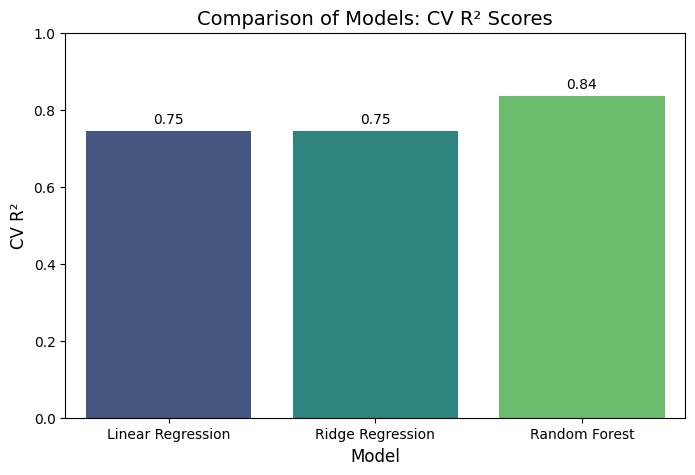

In [17]:
models_list = list(results.keys())
r2_scores = list(results.values())

# Plot
plt.figure(figsize=(8,5))
sns.barplot(x=models_list, y=r2_scores, palette="viridis")
plt.title("Comparison of Models: CV R² Scores", fontsize=14)
plt.ylabel("CV R²", fontsize=12)
plt.xlabel("Model", fontsize=12)
plt.ylim(0,1)  # R² ranges from 0 to 1
for i, v in enumerate(r2_scores):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontsize=10)
plt.show()

### Effect of Outlier Removal
- Removed extreme charges using IQR method.
- Observation:
    - CV R² decreased from 0.75 → 0.58
    - Why? Outliers contributed to variance that the model could explain easily.
- Insight:
    - R² can be **misleading with outliers**.
    - Outlier removal makes predictions more stable and realistic, even if R² drops.


In [12]:
# Remove outliers outside the pipeline
Q1 = df['charges'].quantile(0.25)
Q3 = df['charges'].quantile(0.75)
IQR = Q3 - Q1
df_no_out = df[(df['charges'] >= Q1 - 1.5*IQR) & (df['charges'] <= Q3 + 1.5*IQR)]

X_no_out = df_no_out.drop('charges', axis=1)
y_no_out = df_no_out['charges']


In [13]:
results = {}
for name, model in models.items():
    pipeline = Pipeline([
        ('interactions', interaction_transformer),
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    
    cv_scores = cross_val_score(pipeline, X_no_out, y_no_out, cv=5, scoring='r2')
    results[name] = cv_scores.mean()
    print(f"{name} CV R²: {cv_scores.mean():.4f}")




Linear Regression CV R²: 0.5889
Ridge Regression CV R²: 0.5888
Random Forest CV R²: 0.5813


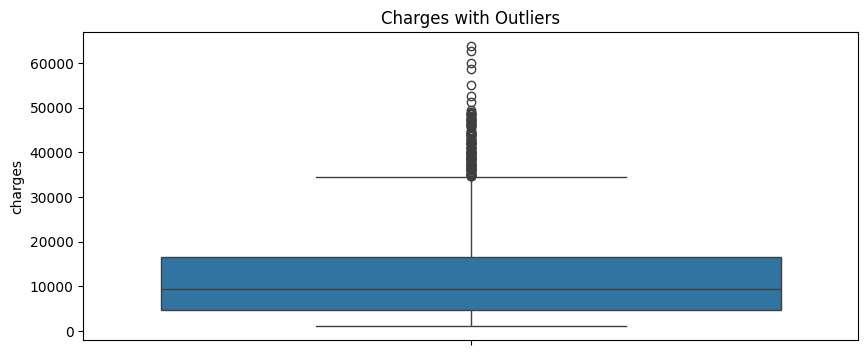

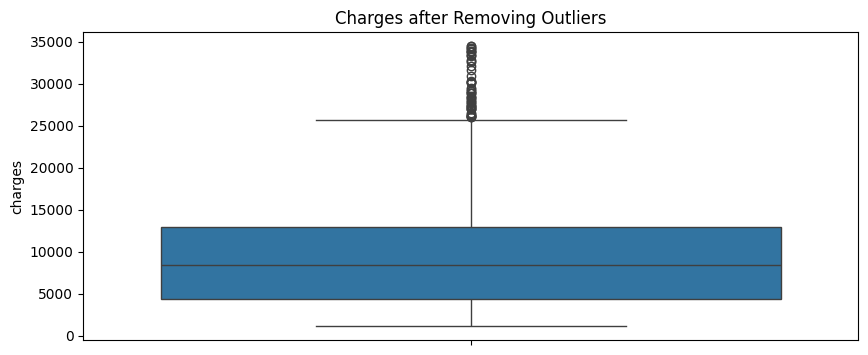

In [16]:
plt.figure(figsize=(10,4))
sns.boxplot(df['charges'])
plt.title("Charges with Outliers")
plt.show()

plt.figure(figsize=(10,4))
sns.boxplot(df_no_out['charges'])
plt.title("Charges after Removing Outliers")
plt.show()

